In [1]:
# Imports

import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import glob
import random
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# vehicles:  8792
# non vehicles:  8968


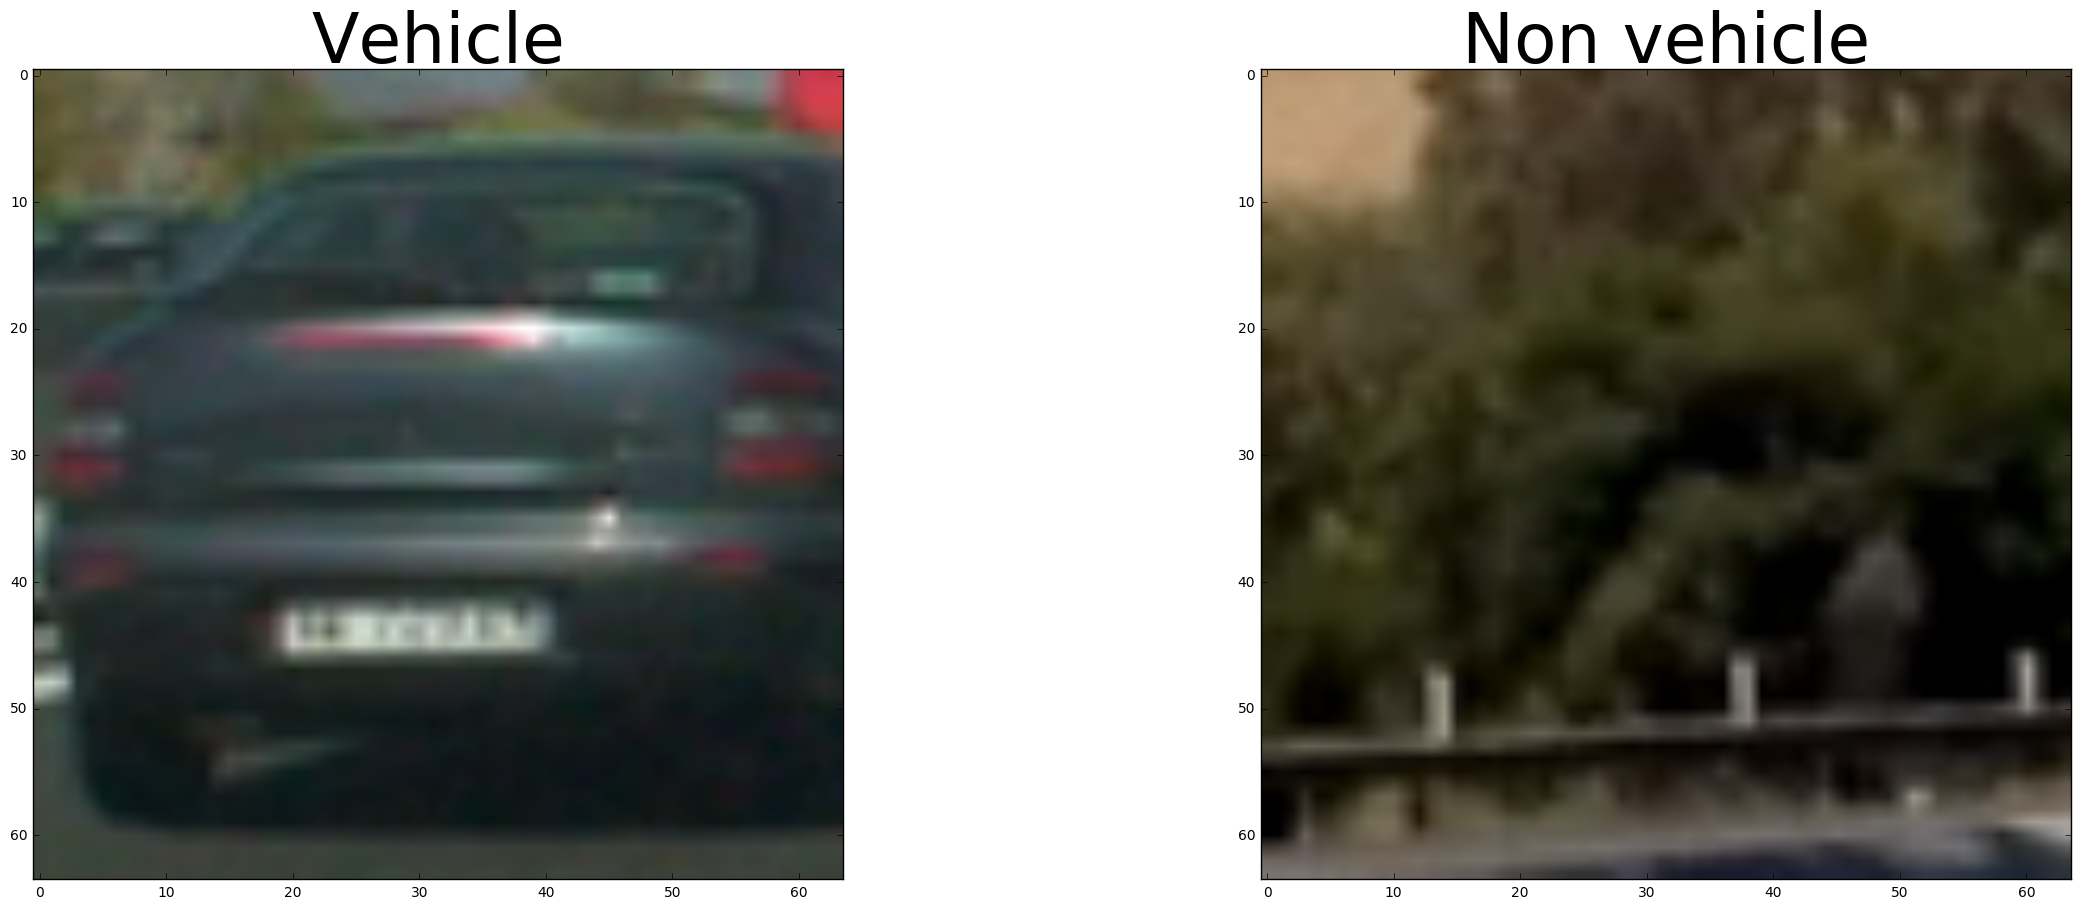

In [2]:
# Load training data files into memory

# Relative path to the vehicle and non vehicles image.
vehicle_pngs = []
non_vehicle_pngs = []
for image in glob.glob("*vehicles/*/*.png"):
    if 'non-vehicles' in image:
        non_vehicle_pngs.append(image)
    else:
        vehicle_pngs.append(image)

print('# vehicles: ', len(vehicle_pngs))
print('# non vehicles: ', len(non_vehicle_pngs))

rand_vehicle = random.choice(vehicle_pngs)
rand_non_vehicle = random.choice(non_vehicle_pngs)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(rand_vehicle))
ax1.set_title('Vehicle', fontsize=50)
ax2.imshow(mpimg.imread(rand_non_vehicle))
ax2.set_title('Non vehicle', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Hog feature extraction

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    """Returns the hog features for a given image based on the params.
    
    Args:
        img: input grayscale image.
        orient: # orientation bins.
        pix_per_cell: # pixels per cell for hog aggregation.
        cell_per_block: # cells per block
        vis: If true, return the hog image visualization.
        feature_vec: If true, return the data as feature vector.
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

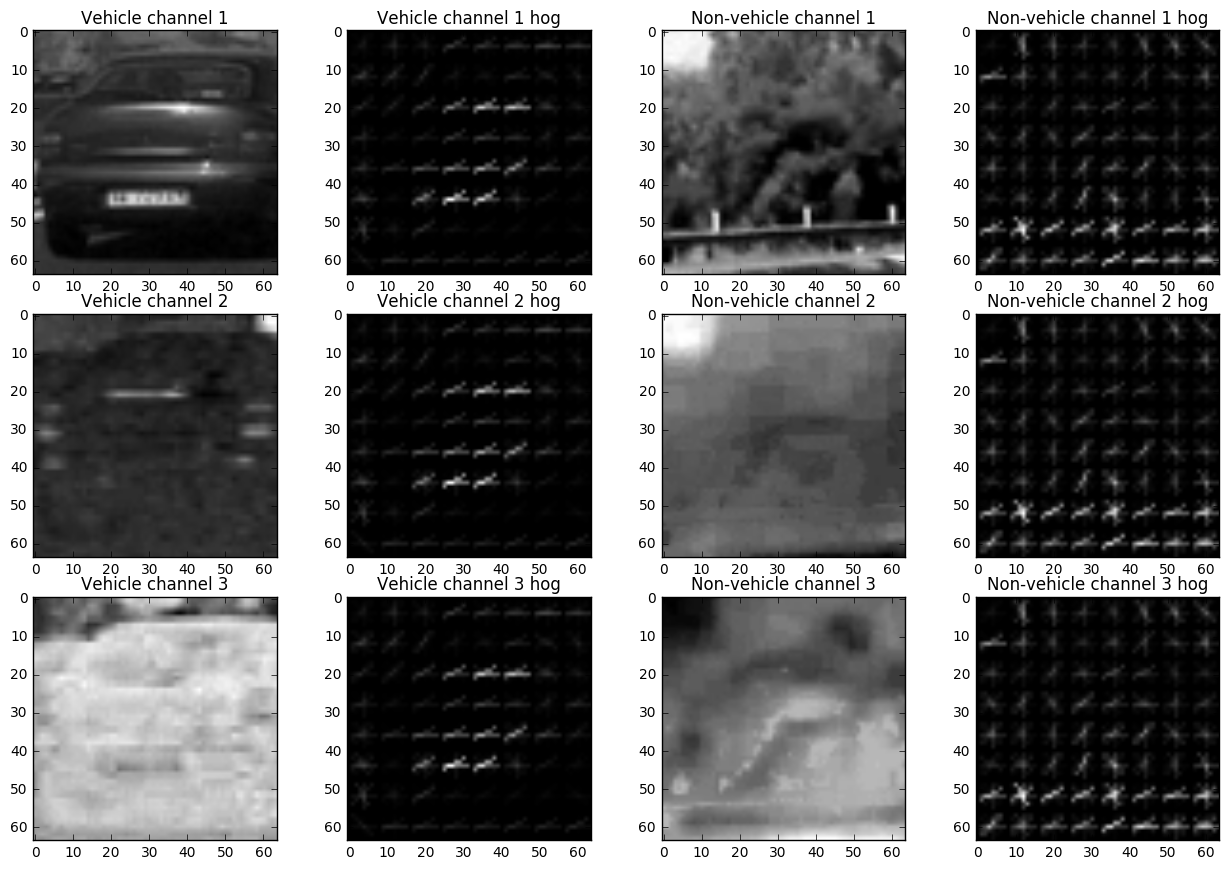

In [26]:
# Visualize hog features

def VisualizeHogFeature(vehicle_img, non_vehicle_img):
    v1_feature, v1_img = get_hog_features(
        vehicle_img[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    v2_feature, v2_img = get_hog_features(
        vehicle_img[:,:,1], 8, 8, 2, vis=True, feature_vec=False)
    v3_feature, v3_img = get_hog_features(
        vehicle_img[:,:,2], 8, 8, 2, vis=True, feature_vec=False)
    nv1_feature, nv1_img = get_hog_features(
        non_vehicle_img[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    nv2_feature, nv2_img = get_hog_features(
        non_vehicle_img[:,:,1], 8, 8, 2, vis=True, feature_vec=False)
    nv3_feature, nv3_img = get_hog_features(
        non_vehicle_img[:,:,2], 8, 8, 2, vis=True, feature_vec=False)

    fig = plt.figure()
    f, axis = plt.subplots(3, 4, figsize=(12, 9))
    f.tight_layout()
    for channel in range(3):
        axis[channel,0].imshow(vehicle_img[:,:,channel], cmap='gray')
        axis[channel,0].set_title('Vehicle channel %d'%(channel + 1), fontsize=12)
        axis[channel,1].imshow(v1_img, cmap='gray')
        axis[channel,1].set_title('Vehicle channel %d hog'%(channel + 1), fontsize=12)
        axis[channel,2].imshow(non_vehicle_img[:,:,channel], cmap='gray')
        axis[channel,2].set_title('Non-vehicle channel %d'%(channel + 1), fontsize=12)
        axis[channel,3].imshow(nv1_img, cmap='gray')
        axis[channel,3].set_title('Non-vehicle channel %d hog'%(channel + 1), fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

VisualizeHogFeature(
    cv2.cvtColor(mpimg.imread(rand_vehicle), cv2.COLOR_RGB2YCrCb),
    cv2.cvtColor(mpimg.imread(rand_non_vehicle), cv2.COLOR_RGB2YCrCb)
)

In [30]:
# Image feature extraction
 
def bin_spatial(img, size=(32, 32)):
    """Computes raw pixel for the image.
    
    Args:
        size: The width/height of the final image size to extract the raw pixels.
    """
    return cv2.resize(img, size).ravel() 

def color_hist(img, nbins=32):
    """Computes the color histogram feature.
    
    Args:
        nbins: The number of histogram bins to bin each channel.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     hog_orient=8, hog_pix_per_cell=8, hog_cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    """Extract features from the given image paths.
    
    Args:
        imgs: The list of image paths to extract features.
        color_space: The color space to extract features on.
        spatial_size: Resized image size to extract features on.
        hog_orient: # hog orientations bins.
        hog_pix_per_cell: # pixels per cell for hog features.
        hog_cell_per_block: # cells per block for hog features.
        hog_channel: If 'ALL', extract features from all the hog channels.
                     Else, it is an integer denoting the channel to be extracted.
        spatial_feat: If true, returns the spatial feature (i.e. the raw pixels).
        hist_feat: If true, returns the color histogram feature.
        hog_feat: If true, returns the hog feature.
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(
                        get_hog_features(
                            feature_image[:,:,channel], 
                            hog_orient, hog_pix_per_cell, hog_cell_per_block, 
                            vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(
                    feature_image[:,:,hog_channel], hog_orient, 
                    hog_pix_per_cell, hog_cell_per_block,
                    vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.copy(features)

# Hyperparameters.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    

vehicle_features = extract_features(
    vehicle_pngs, color_space=color_space, 
    spatial_size=spatial_size, hist_bins=hist_bins, 
    hog_orient=orient, hog_pix_per_cell=pix_per_cell, 
    hog_cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
non_vehicle_features = extract_features(
    non_vehicle_pngs, color_space=color_space, 
    spatial_size=spatial_size, hist_bins=hist_bins, 
    hog_orient=orient, hog_pix_per_cell=pix_per_cell, 
    hog_cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(vehicle_features.shape)

(8792, 2580)


In [16]:
# Visualize feature vectors.

def VisualizeFeatures(v_feature, v_scaled_feature, nv_feature, nv_scaled_feature):
    """Visualize feature vectors for (vehicle, non_vehicle) x (original, scaled)
    """
    fig = plt.figure()
    fig, axis = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle('Feature vector', fontsize=24)
    axis[0, 0].plot(v_feature)
    axis[0, 0].set_yscale('log')
    axis[0, 0].set_title('Vehicle: Before normalizing')
    
    axis[0, 1].plot(v_scaled_feature)
    axis[0, 1].set_title('Vehicle: After StandardScaler')
    
    axis[1, 0].plot(nv_feature)
    axis[1, 0].set_yscale('log')
    axis[1, 0].set_title('Non-vehicle: Before normalizing')
    
    axis[1, 1].plot(nv_scaled_feature)
    axis[1, 1].set_title('Non-vehicle: After StandardScaler')

X shape:  (17760, 2580)
Y shape:  (17760,)


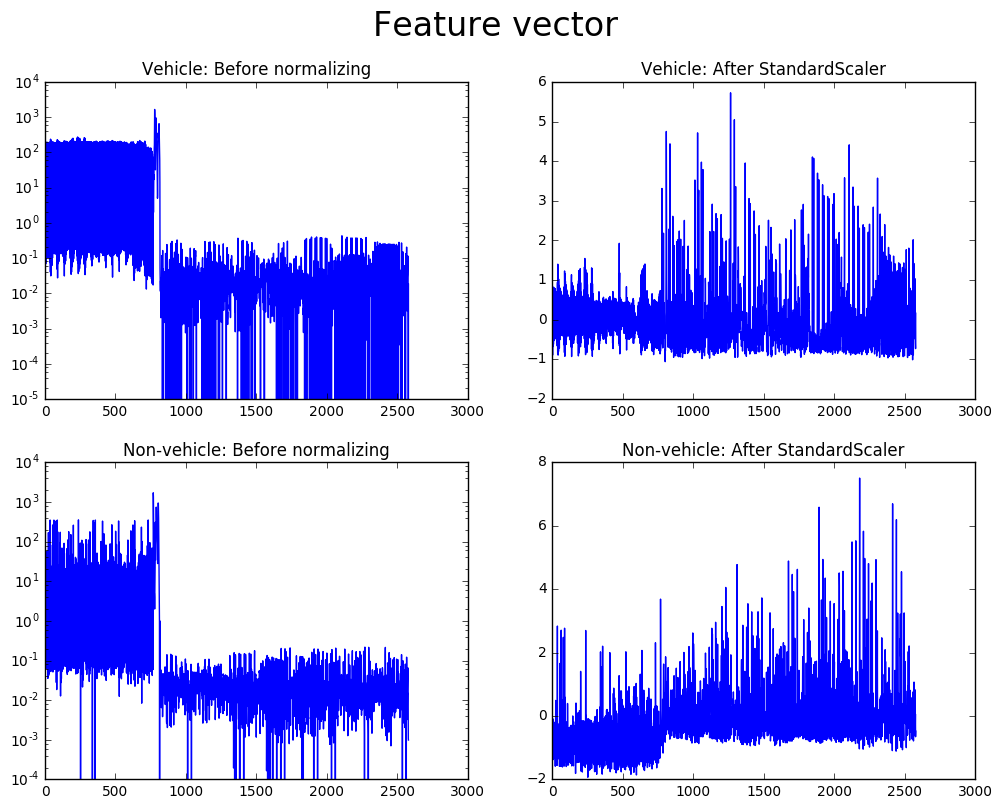

In [31]:
# Prepare and normalize data

# Define the features.
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

X_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Visualize feature vectors for vehicle vs non-vehicle
VisualizeFeatures(X[8], scaled_X[8], X[-36], scaled_X[-36])
# VisualizeFeatures(X[74], scaled_X[74], X[-1255], scaled_X[-1255])
# VisualizeFeatures(X[200], scaled_X[200], X[-332], scaled_X[-332])
print('X shape: ', X.shape)
print('Y shape: ', y.shape)

In [32]:
# Train classifier.

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=123)

def PrintHyperparameterSetting():
    """Print a string about the hyperparameters"""
    print("===== Hyperparameter setting =====")
    print('Color space: %s'%color_space)
    if hog_feat:
        print('Hog: %d orientations, %d pixel per cell, %d cell per block, channel %s'
              %(orient,pix_per_cell,cell_per_block,str(hog_channel)))
    if spatial_feat:
        print('Spatial: size: ', spatial_size)
    if hist_feat:
        print('Histogram: %d bins'%hist_bins)
    print("===== End Hyperparameter setting =====")

PrintHyperparameterSetting()
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
start_time=time.time()
svc.fit(X_train, y_train)
end_time = time.time()

print(round(end_time - start_time, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

===== Hyperparameter setting =====
Color space: HLS
Hog: 9 orientations, 8 pixel per cell, 2 cell per block, channel 1
Spatial: size:  (16, 16)
Histogram: 16 bins
===== End Hyperparameter setting =====
Feature vector length: 2580
9.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9851
